In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import gtsa

from gtsa import temporal, plotting, utils

In [4]:
import os
import glob
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [58]:
data_dir = gtsa.pathlib.Path('/mnt/storage/knuth/sites/scg/hsfm_data/final_products')
dems_fn       = sorted(data_dir.glob('dem*.tif'))
orthos_fn      = sorted(data_dir.glob('ortho*.tif'))

data_dir    = gtsa.pathlib.Path('/mnt/storage/knuth/sites/scg/hsfm_data')
glacier_fn     = data_dir.joinpath('rgi_glacier_oultine.geojson')
reference_dem  = data_dir.joinpath('reference_dem_5m.tif')

assert len(dems_fn) == len(orthos_fn)
assert gtsa.io.parse_timestamps(dems_fn) == gtsa.io.parse_timestamps(orthos_fn)

date_times = [d for d in gtsa.io.parse_timestamps(dems_fn)]
dates = [d.date() for d in date_times]
len(dates)

18

In [59]:
ds = gtsa.io.xr_stack_geotifs(dems_fn,
                              date_times,
                              reference_dem,
                              resampling="bilinear",
                              save_to_nc = False)

Resampled 18 of 18 dems to match reference DEM spatial_ref, crs, transform, bounds, and resolution.


In [60]:
with np.load('prediction_stack.npz') as npz:
    prediction_stack = np.ma.MaskedArray(**npz)

In [72]:
X = gtsa.temporal.create_prediction_timeseries(start_date = dates[0].strftime("%Y-%m-%d"),
                                               end_date = dates[-1].strftime("%Y-%m-%d"),
                                               dt ='M')

X_dates = [utils.decyear_to_date_time(i).date() for i in X]
X_date_times = [datetime.datetime(t.year, t.month, t.day) for t in X_dates]

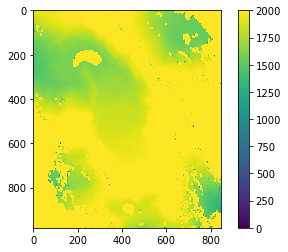

In [92]:
glacier_gdf = gtsa.utils.get_largest_glacier_from_shapefile(glacier_fn)
datasets=[]
for i,v in enumerate(prediction_stack.data):
    tmp_da = ds['band1'].isel(time=0).drop('time')
    tmp_da.values = v
#     tmp_da.values = tmp_da.rio.clip(glacier_gdf.geometry)
    tmp_da = tmp_da.assign_coords({"time": X_date_times[i]})
    tmp_da = tmp_da.expand_dims("time")
    
    datasets.append(tmp_da)
    
ds_new = gtsa.io.xr.concat(datasets, dim="time", combine_attrs="no_conflicts")

In [93]:
ds_new = ds_new.rio.clip(glacier_gdf.geometry)

In [94]:
datasets=[]

for i,v in enumerate(ds_new):
    try:
        tmp_da = ds_new[i+1] - v
        tmp_da = tmp_da.assign_coords({"time": X[i]})
        tmp_da = tmp_da.expand_dims("time")
    except:
        pass
    datasets.append(tmp_da)
    
    
ds_new = gtsa.io.xr.concat(datasets, dim="time", combine_attrs="no_conflicts")

In [95]:
arr = ds_new.data

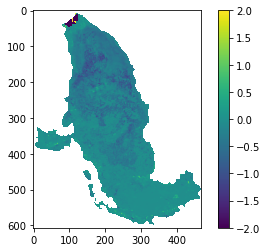

In [99]:
plt.colorbar(plt.imshow(arr[0],vmin=-2,vmax=2))

In [102]:
ds_new = ds_new.where((ds_new > -1.) & (ds_new < 1.), np.nan) 

In [120]:
arr = ds_new.data

In [121]:
np.nanmin(arr)

-0.9998779

In [122]:
np.nanmax(arr)

0.9998779

In [123]:
# gtsa.plotting.plot_timelapse(arr, vmin=-1,vmax=1,cmap='RdBu')

gtsa.plotting.plot_timelapse(arr, vmin=-1,vmax=1,cmap='RdBu', output_file='gpr.mp4')

In [107]:
net = []
for i in arr:
    net.append(np.nanmean(i.flatten()*12))

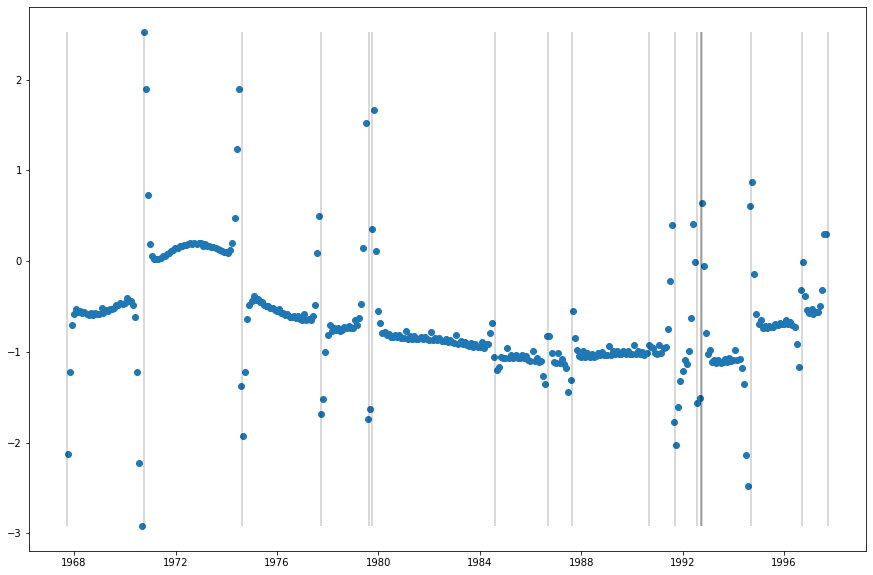

In [108]:
fig,ax = plt.subplots(figsize=(15,10))
ax.vlines(date_times, ymin=np.nanmin(net), ymax=np.nanmax(net), color='k', alpha=0.2)
# ax.set_ylim((-1000, 1000))
ax.scatter(X_date_times, net)

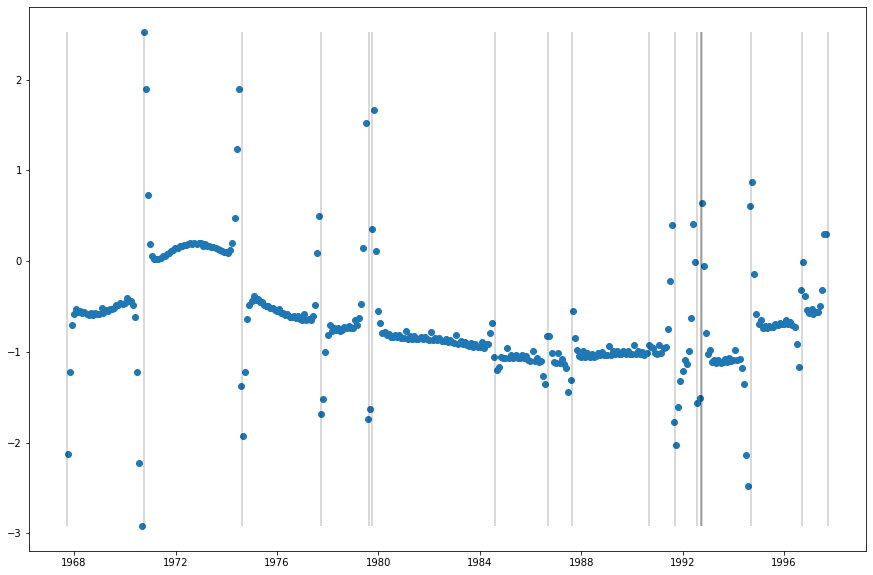

In [109]:
fig,ax = plt.subplots(figsize=(15,10))
ax.vlines(date_times, ymin=np.nanmin(net), ymax=np.nanmax(net), color='k', alpha=0.2)
ax.scatter(X_date_times, net)


In [110]:
ds = ds.rio.clip(glacier_gdf.geometry)

In [111]:
arr = ds['band1'].data

In [112]:
net_v = []
for i in net:
    net_v.append(i *2*2)

In [113]:
coverage = []
for i in arr:
    coverage.append(np.count_nonzero(~np.isnan(i)))

In [114]:
coverage_pct = []
for i in coverage:
    coverage_pct.append(i / np.max(coverage))

In [115]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

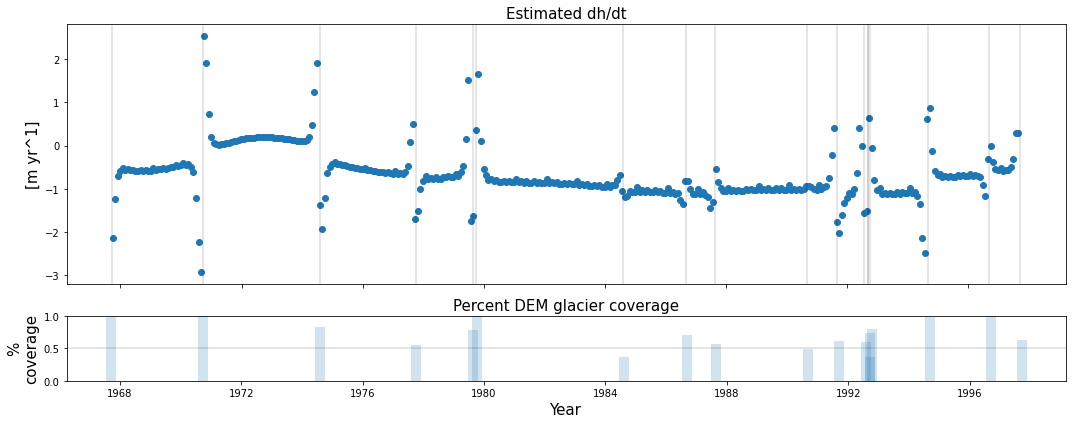

In [116]:
fig = plt.figure(figsize=(15,6))
gs = GridSpec(2, 1, height_ratios=[4, 1])


axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

ax = axes[0]
ax.scatter(X_date_times, net)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.vlines(date_times, ymin=ylim[0], ymax=ylim[1], color='k', linewidth=0.2)
ax.set_ylim(ylim)
# ax.set_ylim((-50000, 50000))
ax.set_ylabel('[m yr^1]', size=15)
ax.set_title('Estimated dh/dt', size=15)
ax.tick_params('x', labelbottom=False)

ax = axes[1]
ax.vlines(date_times, ymin=0, ymax=coverage_pct, alpha=0.2, linewidth=10)
ax.hlines(0.5, xmin=xlim[0], xmax=xlim[1], color='k', linewidth=0.2)
ax.set_ylim([0, 1])
ax.set_xlim(xlim)
ax.set_xlabel('Year', size=15)
ax.set_ylabel('%\ncoverage', size=15)
ax.set_title('Percent DEM glacier coverage', size=15)
# axes[0].get_shared_x_axes().join(axes[0], *axes)

plt.tight_layout()

In [117]:
import numpy as np
np.nanmean(net) * 0.9

-0.599208927154541

In [118]:
np.nanmean(net)

-0.6657877